In [1]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import importlib
import os
import datetime
import random
import math

import config


importlib.reload(config)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\kuzga\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\kuzga\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


<module 'config' from 'c:\\Users\\kuzga\\OneDrive\\Рабочий стол\\ShiftLab-2024-Computer-Vision\\config.py'>

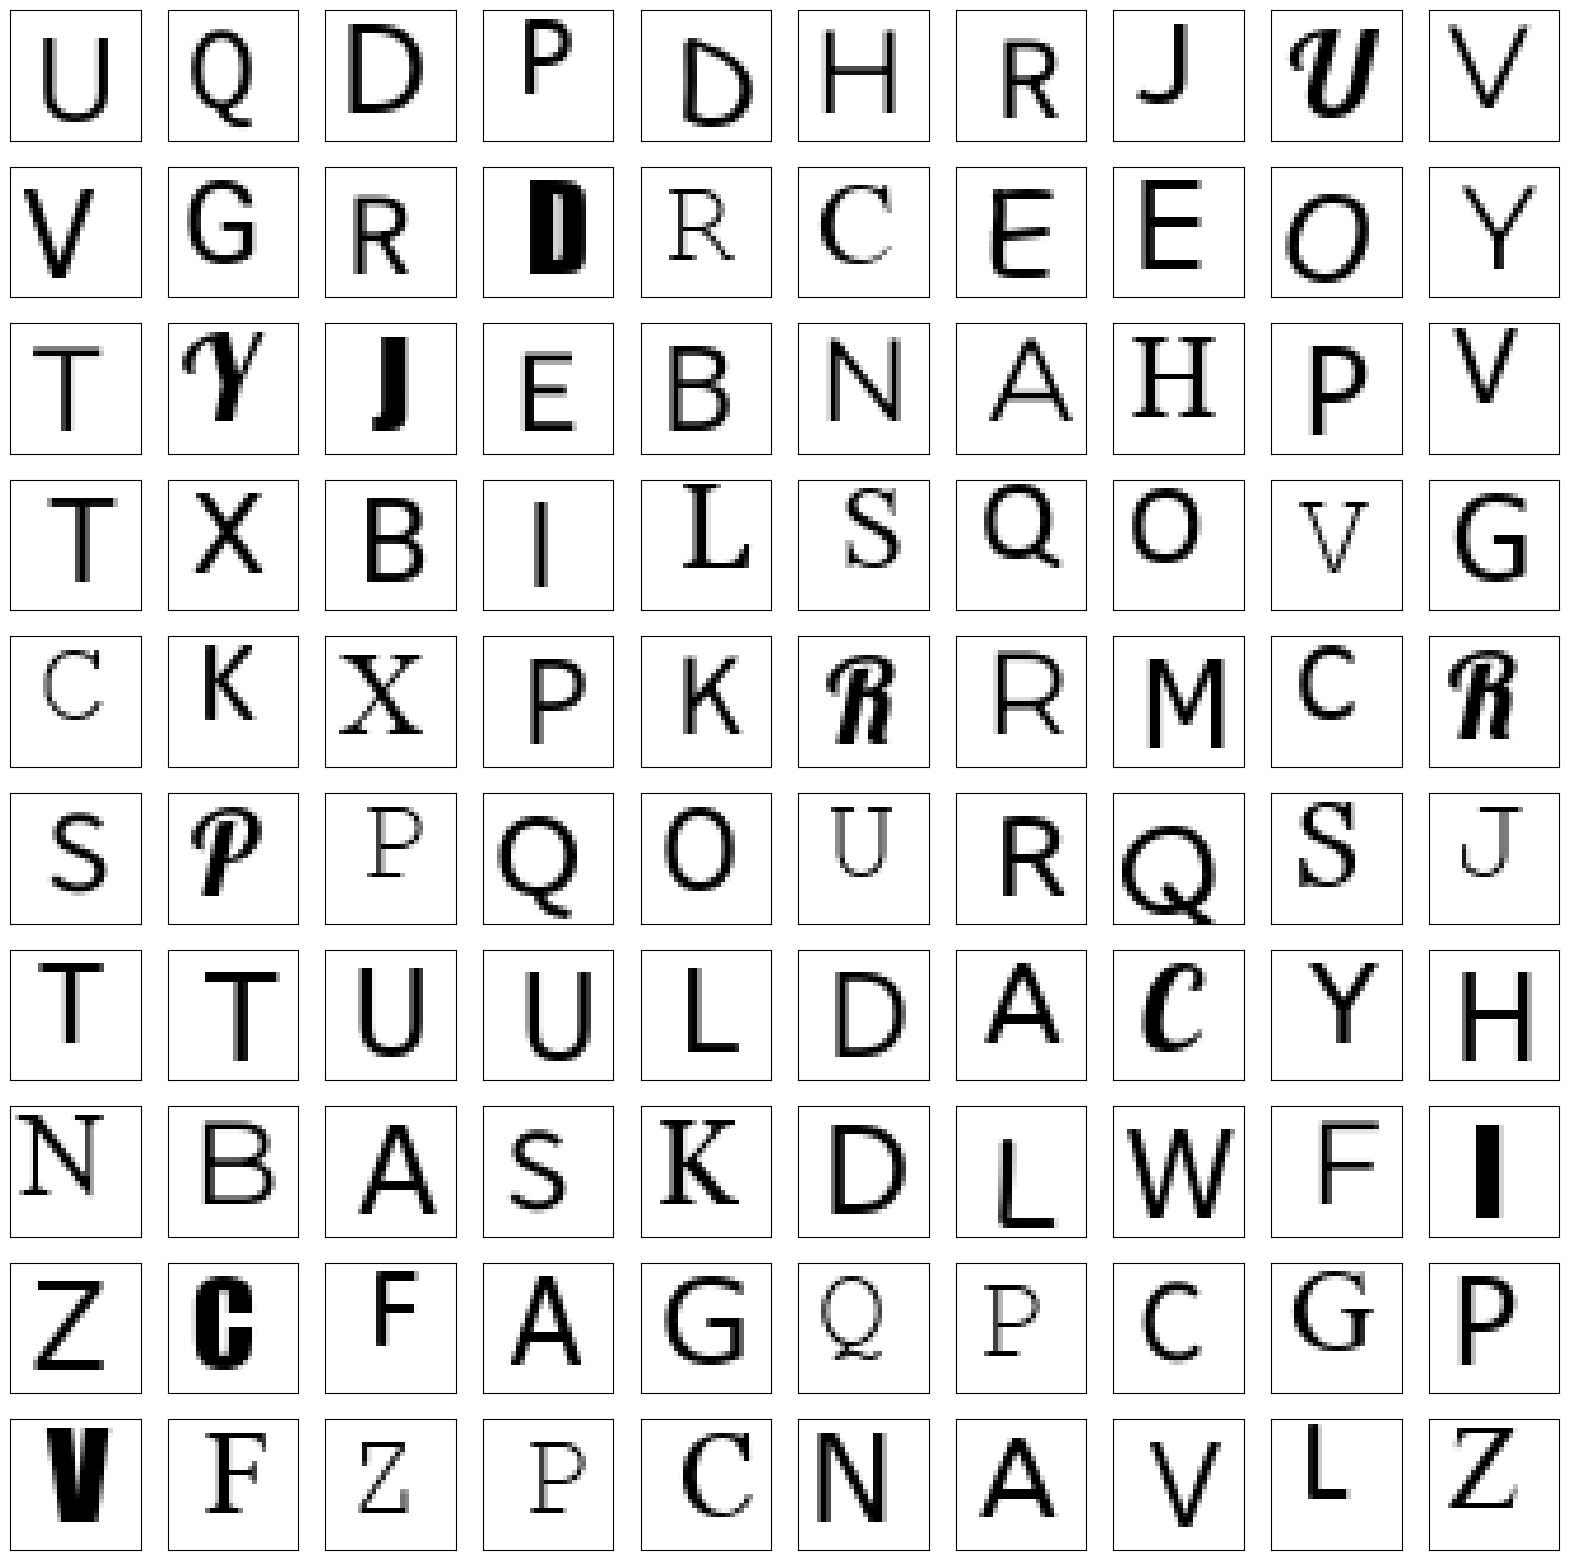

In [2]:
def generate_letter_image(letter=None, size=28, font_path=None, uppercase=None, shift=False):
    """
    Генерирует одноканальное изображение с одной буквой.
    Args:
        letter : str, optional
            Буква для генерации. Если не указана, случайная буква будет выбрана из латинского алфавита (A-Z).
        size : int, optional
            Размер изображения в пикселях (по умолчанию 28). Указывает на ширину и высоту создаваемого изображения.
        font_path : str, optional
            Путь к файлу шрифта (TTF). Если не указан, будет случайно выбран шрифт из предопределенного списка `config.fonts_paths`.
        uppercase : bool, optional
            Если True, буква будет преобразована в верхний регистр. Если False, буква будет в нижнем регистре.
            Если параметр не указан, регистр выбирается случайным образом.
        shift : bool, optional
            Если True, буква будет случайным образом смещена по горизонтали и вертикали на небольшое значение для создания
            эффекта случайного размещения. По умолчанию False (без смещения).
    Returns:
        tuple
            Кортеж из трех элементов:
            1. cv_image : np.ndarray
                Изображение с буквой в формате массива NumPy.
            2. letter : str
                Сгенерированная буква.
            3. font_path : str
                Путь к шрифту, который был использован для создания изображения.
    Example:
        image, letter, font = generate_letter_image(size=50, uppercase=True, shift=True)
    """
    if letter is None:
        letter = random.choice([chr(l) for l in range(ord('a'), ord('z') + 1)])

    if uppercase is None:
        letter = letter.lower() if random.randint(0, 5) else letter.upper()
    else:
        letter = letter.upper() if uppercase else letter.lower()

    if font_path is None:
        font_path = random.choice(config.fonts_paths)
    font_name = font_path.replace('\\', '/').replace('fonts/', '').replace('.ttf', '')

    font_size = math.floor(size * 0.9)
    font = ImageFont.truetype(font_path, font_size)

    image = Image.new("L", (size, size), 255)
    draw = ImageDraw.Draw(image)

    bbox = draw.textbbox((0, 0), letter, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    # print(text_height)
    max_x_shift = math.floor(text_width * 0.25)
    # max_y_shift = math.floor(1)
    random_x_shift = random.randint(-2, 2) if shift else 0
    random_y_shift = random.randint(-1, 1) if shift else 0

    x = (size - text_width) // 2 + random_x_shift
    y = -text_height // 8 + random_y_shift

    draw.text((x, y), letter, font=font, fill=0)
    cv_image = np.array(image)
    return cv_image, letter, font_path

example_size = 100
letter_images = [generate_letter_image(uppercase=True, shift=True) for _ in range(example_size)]
plt.figure(figsize=(20, 2 * example_size // 10))
for i in range(example_size):
    ax = plt.subplot(example_size // 10, 10, i + 1)
    plt.imshow(letter_images[i][0], cmap='gray')
    plt.xticks([])
    plt.yticks([])

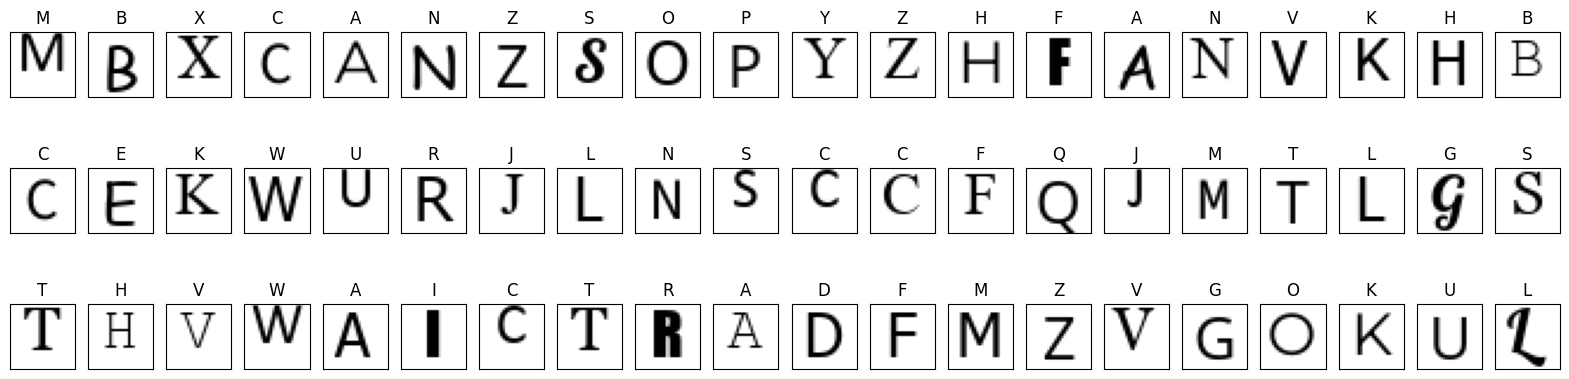

In [3]:
batch_size = 1024

# Создаем свой кастомный датасет, который на самом деле будет на лету генерировать новые изображения с буквой.
class AlphabetDataset(Dataset):
    def __init__(self, batch_size, size=28, font_paths=None, uppercase=True, shift_letters=False, transforms=None):
        self.size = size
        self.batch_size = batch_size
        self.font_paths = font_paths
        self.shift_letters = shift_letters
        self.transforms = transforms
        self.letters = [chr(l) for l in range(ord('a'), ord('z') + 1)]

    def __len__(self):
        return self.batch_size

    def __getitem__(self, idx):
        letter = random.choice(self.letters)
        image, letter, font = generate_letter_image(letter=letter, font_path=self.font_paths, uppercase=True, shift=self.shift_letters)
        if self.transforms:
            image = self.transforms(image)
        return image, ord(letter) - ord('A'), font

# Создаем датасет, в котором сгенерированные на cv2 изображения будут преобразововаться в тензор и нормализовываться для улучшения сходимости модели.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = AlphabetDataset(batch_size, transforms=transform, shift_letters=False)
test_dataset = AlphabetDataset(batch_size, transforms=transform, shift_letters=False)

# Создаем даталоадеры.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Смотрим первые 60 изображений из датасета, чтобы убедиться что они в нужном формате.
real_samples, letters, font = next(iter(train_loader))
plt.figure(figsize=(20, 5))
for i in range(60):
    ax = plt.subplot(3, 20, i + 1)
    plt.title(chr(letters[i].item() + ord('A')))
    plt.imshow(real_samples[i].squeeze(), cmap="gray")
    plt.xticks([])
    plt.yticks([])
plt.show()


In [4]:
def label_to_onehot(labels, length):
    """
    Преобразует тензор меток в формат one-hot кодирования, чтобы в последующем передать эту информацию генератору.
    Args:
    labels : torch.Tensor
        Тензор, содержащий метки для преобразования.
    length : int
        Длина one-hot кодирования (количество классов).
    Returns:
        torch.Tensor
            Тензор размером (batch_size, length), представляющий one-hot кодированные метки.
    """
    batch_size = labels.size(0)
    canvas = torch.zeros(batch_size, length)
    labels = labels.view(-1, 1)
    return canvas.scatter_(1, labels, 1)


def make_binary_labels(num_one, num_zero):
    """
    Создает бинарный тензор меток с заданным количеством единиц и нулей, который в последущем передается дискриминатору.
    Args:
        num_one : int
            Количество единиц в выходном тензоре.
        num_zero : int
            Количество нулей в выходном тензоре.
    Returns:
        torch.Tensor
            Тензор размером (num_one + num_zero, 1), содержащий заданное количество единиц и нулей.
    """
    ones = torch.ones(1, num_one)
    zeros = torch.zeros(1, num_zero)
    return torch.cat([ones, zeros], dim=1).view(-1, 1)

In [5]:
# Выбираем cpu в качестве устройства, так как такие маленькие модели на CUDA обучаются дольше.
device = torch.device("cpu")
# if torch.cuda.is_available():
#     device = torch.device("cuda")
print(f"Device is {device}")

Device is cpu


In [6]:
# Класс генератора с простой MLP архитектурой и ReLU в качестве функций активации.
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(126, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, z, c):
        # конкатим шум и one-hot вектор с информацией о букве
        x = torch.cat([z, c], dim=1)
        x = self.mlp(x)
        return x.view(-1, 1, 28, 28)


# Класс дискриминатора с простой MLP архитектурой и ReLU в качестве функций активации, а также дропаутами для защиты от переобучения генератора.
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(810, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, c):
        img = img.view(-1, 28 * 28)
        # конкатим шум и one-hot вектор с информацией о букве
        x = torch.cat([img, c], dim=1)
        x = self.mlp(x)
        return x


discriminator = Discriminator().to(device)
generator = Generator().to(device)

In [7]:
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.mlp = nn.Sequential(
#             nn.Linear(126, 256),
#             nn.BatchNorm1d(256),
#             nn.ELU(),
#             nn.Linear(256, 512),
#             nn.Linear(512, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ELU(),
#             nn.Linear(1024, 784),
#             nn.Tanh(),
#         )

#     def forward(self, z, c):
#         x = torch.cat([z, c], dim=1)
#         x = self.mlp(x)
#         return x.view(-1, 1, 28, 28)


# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.mlp = nn.Sequential(
#             nn.Linear(810, 1024),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.2),
#             nn.Linear(1024, 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.2),
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.2),
#             nn.Linear(256, 1),
#             nn.Sigmoid(),
#         )

#     def forward(self, img, c):
#         img = img.view(-1, 28 * 28)
#         x = torch.cat([img, c], dim=1)
#         x = self.mlp(x)
#         return x


# discriminator = Discriminator().to(device)
# generator = Generator().to(device)

In [8]:
lr = 0.01
num_epochs = 10000
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.SGD(discriminator.parameters(), lr=lr, momentum=0.5)
optimizer_generator = torch.optim.SGD(generator.parameters(), lr=lr, momentum=0.5)
# Выбираем в качестве оптимизатора Adam
# optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.9, 0.999))
# optimizer_generator = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.9, 0.999))

Epoch 5150, D Loss: 0.4126, G Loss: 2.5662, MSE: 0.5294, SSIM: 0.0293


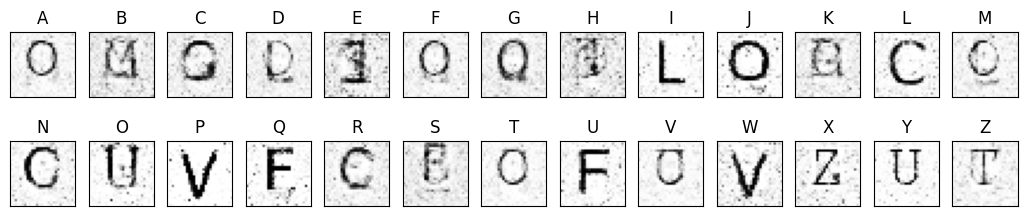

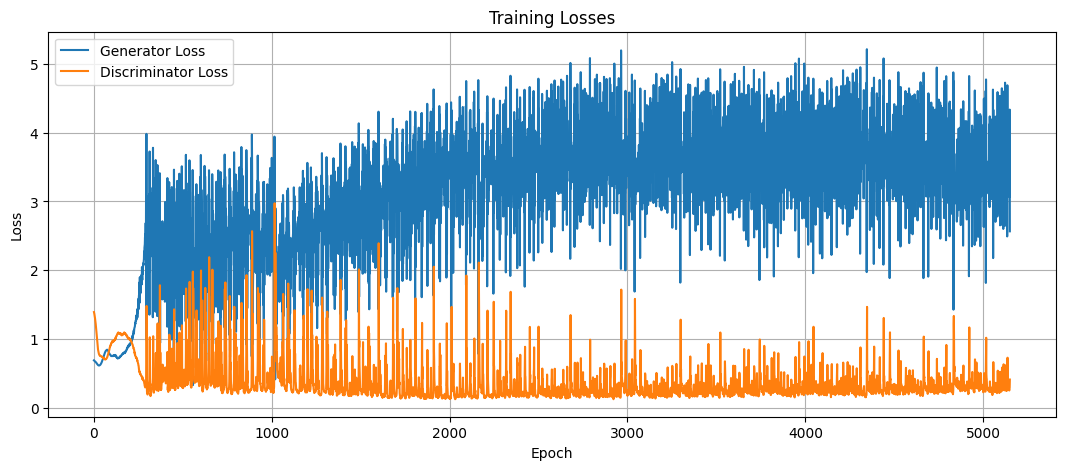

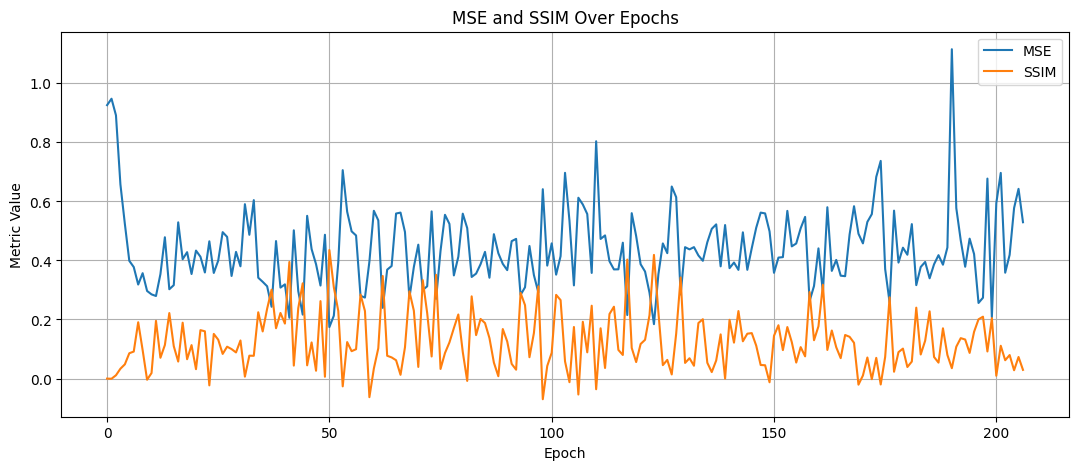

KeyboardInterrupt: 

In [9]:
# Директория текущего эксперимента
output_dir = datetime.datetime.now().strftime("MNIST-GAN-EVO_%Y-%m-%d_%H-%M-%S")
os.makedirs(output_dir, exist_ok=True)

# Фиксированный шум для отслеживания улучшения качества генерации изображений
fixed_noise = torch.randn(26, 100).to(device)

# Лоссы для графиков
generator_losses = []
discriminator_losses = []
mse_scores = []
ssim_scores = []

# Основной цикл обучения
for epoch in range(num_epochs):
    generator_loss_sum = 0
    discriminator_loss_sum = 0
    for img, label, font in train_loader:
        label = torch.tensor(label)
        real = img.to(device)
        onehot = label_to_onehot(label, 26).to(device)
        batch_size = real.size(0)

        # Обучение дискриминатора
        discriminator.train()
        generator.eval()
        z = torch.randn(batch_size, 100).to(device)
        fake = generator(z, onehot).detach()

        fake_out = discriminator(fake, onehot)
        real_out = discriminator(real, onehot)

        fake_y = make_binary_labels(0, batch_size).to(device)
        real_y = make_binary_labels(batch_size, 0).to(device)

        fake_loss = loss_function(fake_out, fake_y)
        real_loss = loss_function(real_out, real_y)

        discriminator_loss = fake_loss + real_loss
        discriminator_loss_sum += discriminator_loss.item()
        optimizer_discriminator.zero_grad()
        discriminator_loss.backward()
        optimizer_discriminator.step()

        # Обучение генератора
        generator.train()
        discriminator.eval()
        z = torch.randn(batch_size, 100).to(device)
        fake = generator(z, onehot)
        fake_out = discriminator(fake, onehot)
        y = make_binary_labels(batch_size, 0).to(device)

        generator_loss = loss_function(fake_out, y)
        generator_loss_sum += generator_loss.item()
        optimizer_generator.zero_grad()
        generator_loss.backward()
        optimizer_generator.step()

    generator_losses.append(generator_loss_sum / len(train_loader))
    discriminator_losses.append(discriminator_loss_sum / len(train_loader))

    if epoch % 25 == 0:
        clear_output(True)

        discriminator.eval()
        generator.eval()

        labels = torch.arange(26).long()
        onehot = label_to_onehot(labels, 26)

        fake = generator(fixed_noise, onehot)

        # Вычисление MSE и SSIM
        fake_images = fake[0].detach().cpu()
        real_images = train_loader.dataset[0][0].unsqueeze(0).to(device)
        mse = np.mean((real_images.cpu().numpy() - fake_images.cpu().numpy()) ** 2)
        ssim_score = ssim(real_images.cpu().detach().numpy().squeeze(), fake_images.numpy().squeeze(), data_range=1.0)

        mse_scores.append(mse)
        ssim_scores.append(ssim_score)

        D_loss_avg = discriminator_loss_sum / len(train_loader)
        G_loss_avg = generator_loss_sum / len(train_loader)
        print(f"Epoch {epoch}, D Loss: {D_loss_avg:.4f}, G Loss: {G_loss_avg:.4f}, MSE: {mse:.4f}, SSIM: {ssim_score:.4f}")

        # Визуализация сгенерированных изображений
        plt.figure(figsize=(13, 4))
        for i in range(26):
            label = labels[i]
            img = fake[i][0].detach().cpu()
            plt.subplot(3, 13, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(chr(i + ord('A')))
            plt.xticks([])
            plt.yticks([])
        plt.savefig(f"{output_dir}/epoch_{epoch}.png")
        plt.show()

        # Сохранение графиков лоссов, FID, MSE и SSIM
        plt.figure(figsize=(13, 5))
        plt.plot(generator_losses, label='Generator Loss')
        plt.plot(discriminator_losses, label='Discriminator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Losses')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{output_dir}/loss_plot.png")
        plt.show()

        # Графики MSE и SSIM
        plt.figure(figsize=(13, 5))
        plt.plot(mse_scores, label='MSE')
        plt.plot(ssim_scores, label='SSIM')
        plt.xlabel('Epoch')
        plt.ylabel('Metric Value')
        plt.title('MSE and SSIM Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{output_dir}/mse_ssim_plot.png")
        plt.show()

torch.save({
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
}, f"{output_dir}/state_dict.pkl")
